# Overview

In this project, I will use Neural Network Matrix Factorization with Keras to predict the ratings for the movies in [MovieLens Small Datasets](https://grouplens.org/datasets/movielens/latest/)


## [Recommender system](https://en.wikipedia.org/wiki/Recommender_system)
A recommendation system is basically an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. It is widely used in different internet / online business such as Amazon, Netflix, Spotify, or social media like Facebook and Youtube. By using recommender systems, those companies are able to provide better or more suited products/services/contents that are personalized to a user based on his/her historical consumer behaviors


## [Neural Collaborative Filtering](https://dl.acm.org/citation.cfm?id=3052569)
This notebook will present a general framework named NCF, short for Neural network-based Collaborative Filtering. NCF is generic and can express and generalize matrix factorization under its framework. To supercharge NCF modelling with non-linearities, I will leverage a multi-layer perceptron to learn the user-item interaction function. Extensive experiments on real-world datasets show significant improvements of our proposed NCF framework over the state-of-the-art methods. Empirical evidence shows that using deeper layers of neural networks offers better recommendation performance.


## Data Sets
We use [MovieLens Small Datasets](https://grouplens.org/datasets/movielens/latest/)
This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100004 ratings and 1296 tag applications across 9125 movies. These data were created by 671 users between January 09, 1995 and October 16, 2016. This dataset was generated on October 17, 2016.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`


## Project Content
1. Load Data
2. Split Data Into Train/Test
3. Train Generalized Matrix Factorization Model and Test Model
4. Train Multi-Layer Perceptron Model and Test Model
5. Train Neural Matrix Factorization Model (NeuMF) and Test Model
6. Experiment Observations
7. Conclusion and Thoughts

NOTE: Train Neural Matrix Factorization Model (NeuMF) is a stacking version of Generalized Matrix Factorization Model and Multi-Layer Perceptron Model

In [1]:
import os

# data science imports
import numpy as np


# keras/tensorflow imports
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

import pandas as pd

# sklearn imports
from sklearn.model_selection import train_test_split

# visualization imports
import matplotlib.pyplot as plt
%matplotlib inline

/home/ivan/.conda/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ivan/.conda/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ivan/.conda/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ivan/.conda/envs/tensorflow/lib/python3.7/s

In [313]:
# path config
data_path = '/home/ivan/ML/MyDataSciencePortfolio-master/movie_recommender/ml-latest-small'
ratings_filename = 'ratings.csv'


## 1. Load Data

In [314]:
df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})
df_movies = pd.read_csv(
    os.path.join(data_path, 'movies.csv'),
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})
print(df_movies)

      movieId                                      title
0           1                           Toy Story (1995)
1           2                             Jumanji (1995)
2           3                    Grumpier Old Men (1995)
3           4                   Waiting to Exhale (1995)
4           5         Father of the Bride Part II (1995)
...       ...                                        ...
9737   193581  Black Butler: Book of the Atlantic (2017)
9738   193583               No Game No Life: Zero (2017)
9739   193585                               Flint (2017)
9740   193587        Bungo Stray Dogs: Dead Apple (2018)
9741   193609        Andrew Dice Clay: Dice Rules (1991)

[9742 rows x 2 columns]


In [315]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100859 entries, 0 to 100858
Data columns (total 3 columns):
userId     100859 non-null int32
movieId    100859 non-null int32
rating     100859 non-null float32
dtypes: float32(1), int32(2)
memory usage: 1.2 MB


In [316]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [317]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 611 unique users and 9724 unique movies in this data set


In [318]:
user_maxId = df_ratings.userId.max()
item_maxId = df_ratings.movieId.max()
print('There are {} distinct users and the max of user ID is also {}'.format(num_users, user_maxId))
print('There are {} distinct movies, however, the max of movie ID is {}'.format(num_items, item_maxId))
print('In the context of matrix factorization, the current item vector is in unnecessarily high dimensional space')
print('So we need to do some data cleaning to reduce the dimension of item vector back to {}'.format(num_items))

There are 611 distinct users and the max of user ID is also 611
There are 9724 distinct movies, however, the max of movie ID is 193609
In the context of matrix factorization, the current item vector is in unnecessarily high dimensional space
So we need to do some data cleaning to reduce the dimension of item vector back to 9724


In [319]:
def reduce_item_dim(df_ratings):
    """
    Reduce item vector dimension to the number of distinct items in our data sets
    
    input: pd.DataFrame, df_ratings should have columns ['userId', 'movieId', 'rating']
    output: pd.DataFrame, df_ratings with new 'MovieID' that is compressed
    """
    # pivot
    df_user_item = df_ratings.pivot(index='userId', columns='movieId', values='rating')
    # reset movieId
    print(df_user_item)
    df_user_item = df_user_item.T.reset_index(drop=True).T
    print(df_user_item)
    # undo pivot/melt - compress data frame
    df_ratings_new = df_user_item \
        .reset_index('userId') \
        .melt(
            id_vars='userId', 
            value_vars=df_user_item.columns,
            var_name='movieId',
            value_name='rating')
    # drop nan and final clean up
    return df_ratings_new.dropna().sort_values(['userId', 'movieId']).reset_index(drop=True)

In [320]:
print('reduce item dimension before:')
df_ratings.head()

reduce item dimension before:


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [321]:
# print(df_ratings['movieId'])
# print(df_movies)
k = pd.merge(df_ratings, df_movies, on='movieId', how='left')
print(k)

        userId  movieId  rating                               title
0            1        1     4.0                    Toy Story (1995)
1            1        3     4.0             Grumpier Old Men (1995)
2            1        6     4.0                         Heat (1995)
3            1       47     5.0         Seven (a.k.a. Se7en) (1995)
4            1       50     5.0          Usual Suspects, The (1995)
...        ...      ...     ...                                 ...
100854     611        6     2.0                         Heat (1995)
100855     611       16     5.0                       Casino (1995)
100856     611        5     1.0  Father of the Bride Part II (1995)
100857     611        4     1.0            Waiting to Exhale (1995)
100858     611        9     2.0                 Sudden Death (1995)

[100859 rows x 4 columns]


In [322]:
df_ratings = reduce_item_dim(df_ratings)
print('reduce item dimension after:')
df_ratings.head()

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     NaN     4.0     NaN     NaN     4.0     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...         ...     ...     ...     ...     ...     ...     ...     ...   
607         4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
608         2.5     2.0     2.0     NaN     NaN     NaN     NaN     NaN   
609         3.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
610         5.0     NaN     NaN     NaN     NaN     5.0     NaN     NaN   
611         5.0     NaN     2.0     1.0     1.0     2.0     NaN     NaN   

movieId  9       10     

,userId,movieId,rating
0,1,0,4.0
1,1,2,4.0
2,1,5,4.0
3,1,43,5.0
4,1,46,5.0


In [323]:
print(df_ratings)

        userId movieId  rating
0            1       0     4.0
1            1       2     4.0
2            1       5     4.0
3            1      43     5.0
4            1      46     5.0
...        ...     ...     ...
100854     611    7307     5.0
100855     611    7675     5.0
100856     611    8133     5.0
100857     611    8138     1.0
100858     611    9584     5.0

[100859 rows x 3 columns]


## 2. Split Data Into Train/Test

In [324]:
# df_train, df_test = train_test_split(df_ratings, test_size=0.2, shuffle=True, random_state=99)
# print('shape of training data set:')
# print(df_train.shape)
# print('shape of test data set:')
# print(df_test.shape)
df_train = df_ratings

## 3. Train Generalized Matrix Factorization and Test Model

### define GMF model architeture and train routine

In [327]:
def get_GMF_model(num_users, num_items, latent_dim, vu_reg, vi_reg):
    """
    Build Generalized Matrix Factorization Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    latent_dim: int, embedded dimension for user vector and item vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of item embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(vu_reg),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(vi_reg),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model


def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
    
    # compile model
    model.compile(optimizer=learner.lower(), loss='mean_squared_error', metrics=['mean_squared_error', rmse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_rmse', patience=3, verbose=1)
    model_saver = ModelCheckpoint(filepath=os.path.join(data_path, 'tmp/model.hdf5'),
                                  monitor='val_rmse',
                                  save_best_only=True,
                                  save_weights_only=True)
    # train model
    history = model.fit(inputs, outputs,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_split,
                        callbacks=[early_stopper, model_saver])
    return history


def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

### create GMF model

In [349]:
GMF_model = get_GMF_model(num_users, num_items, 100, 1, 1)
GMF_model.summary()

Model: "model_92"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 100)       61200       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 100)       972500      item_input[0][0]                 
___________________________________________________________________________________________

### train GMF model

In [350]:
# model config
BATCH_SIZE = 64
EPOCHS = 10
VAL_SPLIT = 0.05

# train model
history = train_model(GMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train.userId.values, df_train.movieId.values],
                      outputs=df_train.rating.values)

Train on 95816 samples, validate on 5043 samples
Epoch 1/10
95816/95816 [==============================] - 60s 628us/sample - loss: 17.1070 - mean_squared_error: 9.0869 - rmse: 2.9897 - val_loss: 5.6813 - val_mean_squared_error: 5.6812 - val_rmse: 2.3811
Epoch 2/10
95816/95816 [==============================] - 62s 652us/sample - loss: 3.7153 - mean_squared_error: 3.7153 - rmse: 1.9079 - val_loss: 2.1707 - val_mean_squared_error: 2.1706 - val_rmse: 1.4717
Epoch 3/10
95816/95816 [==============================] - 62s 642us/sample - loss: 1.6015 - mean_squared_error: 1.6015 - rmse: 1.2569 - val_loss: 1.0847 - val_mean_squared_error: 1.0846 - val_rmse: 1.0378
Epoch 4/10
95816/95816 [==============================] - 62s 651us/sample - loss: 1.1276 - mean_squared_error: 1.1275 - rmse: 1.0578 - val_loss: 0.9485 - val_mean_squared_error: 0.9483 - val_rmse: 0.9702
Epoch 5/10
95816/95816 [==============================] - 62s 645us/sample - loss: 1.0952 - mean_squared_error: 1.0950 - rmse: 1.0

### GMF learning curve

In [183]:
print(df_train.userId.values)
print(df_train.movieId.values)
print(df_train.rating.values)
ind = df_ratings[(df_ratings['userId'] == 611) & (df_ratings['movieId'] == 0)].index.tolist()[0]
print(ind)
print(k.iloc[ind]['movieId'], k.iloc[ind]['title'])

[  1   1   1 ... 611 611 611]
[0 2 5 ... 4536 4980 5393]
[4. 4. 4. ... 5. 5. 5.]
100836
1 Toy Story (1995)


In [344]:
def plot_learning_curve(history, metric):
    """
    Plot learning curve to compare training error vs. validation error
    """
    # get training error
    errors = history.history[metric]
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

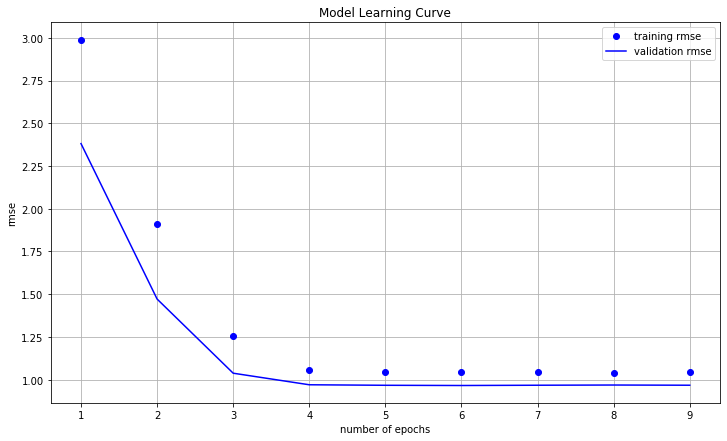

In [351]:
plot_learning_curve(history, 'rmse')

### GMF model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [346]:
# define rmse function
rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions) - np.squeeze(df_test.rating.values))))

In [366]:
# load best model
GMF_model = get_GMF_model(num_users, num_items, 100, 1, 1)
GMF_model = load_trained_model(GMF_model, os.path.join(data_path, 'tmp/modelGMFBest.hdf5'))
# make prediction using test data
my_ind = np.ones(num_items) * 611
my_films = np.arange(0, num_items)
# print(my_ind.shape)
# print(my_films.shape)
predictions = GMF_model.predict([my_ind, my_films])
sort_index = sorted(range(len(predictions)), key=lambda k: predictions[k][0], reverse=True)

for i in range(20):
    ind = df_ratings[df_ratings['movieId'] == sort_index[i]].index.tolist()[0]
    print(k.iloc[ind]['movieId'], k.iloc[ind]['title'], predictions[sort_index[i]])
    
print('\npredictions on your films:\n')

print(k[k['userId']== 611].iloc[:,2:4])

# get the RMSE
# error = rmse(df_test.rating.values, predictions)
# print('The out-of-sample RMSE of rating predictions is', round(error, 4))

1 Toy Story (1995) [3.498193]
2 Jumanji (1995) [3.498193]
3 Grumpier Old Men (1995) [3.498193]
4 Waiting to Exhale (1995) [3.498193]
5 Father of the Bride Part II (1995) [3.498193]
6 Heat (1995) [3.498193]
7 Sabrina (1995) [3.498193]
8 Tom and Huck (1995) [3.498193]
9 Sudden Death (1995) [3.498193]
10 GoldenEye (1995) [3.498193]
11 American President, The (1995) [3.498193]
12 Dracula: Dead and Loving It (1995) [3.498193]
13 Balto (1995) [3.498193]
14 Nixon (1995) [3.498193]
15 Cutthroat Island (1995) [3.498193]
16 Casino (1995) [3.498193]
17 Sense and Sensibility (1995) [3.498193]
18 Four Rooms (1995) [3.498193]
19 Ace Ventura: When Nature Calls (1995) [3.498193]
20 Money Train (1995) [3.498193]

predictions on your films:

        rating                                              title
100836     5.0                                   Toy Story (1995)
100837     5.0                                    Iron Man (2008)
100838     5.0                               Avengers, The (2012)
10

## 4. Train Multi-Layer Perceptron Model and Test Model

In [64]:
print(df_test.userId.values)
print(df_test.movieId.values)
print(df_test.rating.values)


[552 445  21 ... 111 380 263]
[  541  1230  4040 ... 96432   293   380]
[5.  5.  2.5 ... 3.5 5.  4. ]


### define MLP model architeture

In [356]:
def get_MLP_model(num_users, num_items, layers, reg_layers):
    """
    Build Multi-Layer Perceptron Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))

    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])

    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

### create MLP model

In [360]:
MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [1, 1, 1, 1])
MLP_model.summary()

Model: "model_97"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 32)        19584       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 32)        311200      item_input[0][0]                 
___________________________________________________________________________________________

### train MLP model

In [361]:
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.05

# train model
history = train_model(MLP_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train.userId.values, df_train.movieId.values],
                      outputs=df_train.rating.values)

Train on 95816 samples, validate on 5043 samples
Epoch 1/30
95816/95816 [==============================] - 29s 299us/sample - loss: 9.4250 - mean_squared_error: 1.8100 - rmse: 1.2239 - val_loss: 0.9516 - val_mean_squared_error: 0.9515 - val_rmse: 0.9711
Epoch 2/30
95816/95816 [==============================] - 23s 242us/sample - loss: 1.0960 - mean_squared_error: 1.0959 - rmse: 1.0428 - val_loss: 0.9439 - val_mean_squared_error: 0.9439 - val_rmse: 0.9673
Epoch 3/30
95816/95816 [==============================] - 22s 233us/sample - loss: 1.0965 - mean_squared_error: 1.0964 - rmse: 1.0428 - val_loss: 0.9539 - val_mean_squared_error: 0.9536 - val_rmse: 0.9701
Epoch 4/30
95816/95816 [==============================] - 24s 253us/sample - loss: 1.0962 - mean_squared_error: 1.0961 - rmse: 1.0423 - val_loss: 0.9440 - val_mean_squared_error: 0.9439 - val_rmse: 0.9670
Epoch 5/30
95816/95816 [==============================] - 23s 241us/sample - loss: 1.0962 - mean_squared_error: 1.0960 - rmse: 1.04

### MLP learning curve

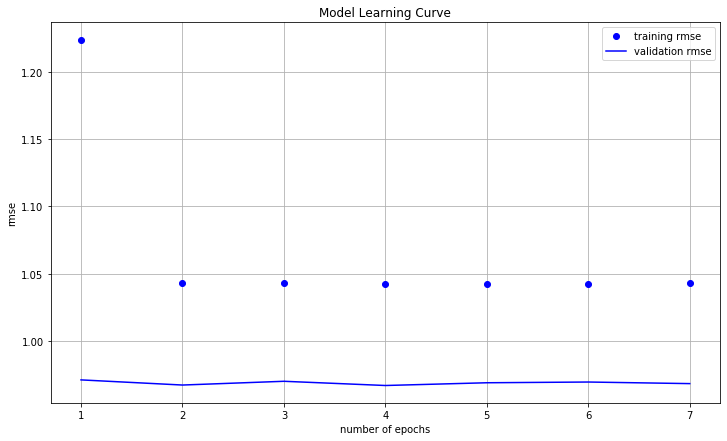

In [362]:
plot_learning_curve(history, 'rmse')

### MLP model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [365]:
# load best model
MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [1, 1, 1, 1])
MLP_model = load_trained_model(MLP_model, os.path.join(data_path, 'tmp/model.hdf5'))
# make prediction using test data
# predictions = MLP_model.predict([df_test.userId.values, df_test.movieId.values])
# # get the RMSE
# error = rmse(df_test.rating.values, predictions)
# print('The out-of-sample RMSE of rating predictions is', round(error, 4))
my_ind = np.ones(num_items) * 611
my_films = np.arange(0, num_items)
# print(my_ind.shape)
# print(my_films.shape)
predictions = MLP_model.predict([my_ind, my_films])
sort_index = sorted(range(len(predictions)), key=lambda k: predictions[k][0], reverse=True)

for i in range(20):
    ind = df_ratings[df_ratings['movieId'] == sort_index[i]].index.tolist()[0]
    print(k.iloc[ind]['movieId'], k.iloc[ind]['title'], predictions[sort_index[i]])
    
print('\npredictions on your films:\n')

print(k[k['userId']== 611].iloc[:,2:4])

1 Toy Story (1995) [3.5327957]
2 Jumanji (1995) [3.5327957]
3 Grumpier Old Men (1995) [3.5327957]
4 Waiting to Exhale (1995) [3.5327957]
5 Father of the Bride Part II (1995) [3.5327957]
6 Heat (1995) [3.5327957]
7 Sabrina (1995) [3.5327957]
8 Tom and Huck (1995) [3.5327957]
9 Sudden Death (1995) [3.5327957]
10 GoldenEye (1995) [3.5327957]
11 American President, The (1995) [3.5327957]
12 Dracula: Dead and Loving It (1995) [3.5327957]
13 Balto (1995) [3.5327957]
14 Nixon (1995) [3.5327957]
15 Cutthroat Island (1995) [3.5327957]
16 Casino (1995) [3.5327957]
17 Sense and Sensibility (1995) [3.5327957]
18 Four Rooms (1995) [3.5327957]
19 Ace Ventura: When Nature Calls (1995) [3.5327957]
20 Money Train (1995) [3.5327957]

predictions on your films:

        rating                                              title
100836     5.0                                   Toy Story (1995)
100837     5.0                                    Iron Man (2008)
100838     5.0                               Ave

## 5. Train Neural Matrix Factorization (NeuMF) and Test Model

### define NeuMF model architeture

In [328]:
def get_NeuMF_model(num_users, num_items, MF_dim, MF_reg, MLP_layers, MLP_regs):
    """
    Build Neural Matrix Factorization (NeuMF) Model Topology.
    This is stack version of both GMF and MLP
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    MF_dim: int, embedded dimension for user vector and item vector in MF
    MF_reg: tuple of float, L2 regularization of MF embedded layer
    MLP_layers: list of int, each element is the number of hidden units for each MLP layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    MLP_regs: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # Embedding layer
    
    # MF
    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_item_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)
    
    # MLP
    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_item_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1) 
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)
    
    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

### create NeuMF model

In [329]:
NeuMF_model = get_NeuMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=100,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model.summary()

Model: "model_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 1, 32)        19584       user_input[0][0]                 
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 1, 32)        311200      item_input[0][0]                 
___________________________________________________________________________________________

### train NeuMF model

In [330]:
# model config
BATCH_SIZE = 64
EPOCHS = 50
VAL_SPLIT = 0.05

# train model
history = train_model(NeuMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train.userId.values, df_train.movieId.values],
                      outputs=df_train.rating.values)

Train on 95816 samples, validate on 5043 samples
Epoch 1/50
95816/95816 [==============================] - 36s 378us/sample - loss: 1.3319 - mean_squared_error: 1.3319 - rmse: 1.0274 - val_loss: 1.1297 - val_mean_squared_error: 1.1297 - val_rmse: 1.0609
Epoch 2/50
95816/95816 [==============================] - 34s 353us/sample - loss: 0.6049 - mean_squared_error: 0.6049 - rmse: 0.7724 - val_loss: 0.9580 - val_mean_squared_error: 0.9580 - val_rmse: 0.9756
Epoch 3/50
95816/95816 [==============================] - 33s 346us/sample - loss: 0.2682 - mean_squared_error: 0.2682 - rmse: 0.5138 - val_loss: 0.9540 - val_mean_squared_error: 0.9540 - val_rmse: 0.9739
Epoch 4/50
95816/95816 [==============================] - 36s 371us/sample - loss: 0.1271 - mean_squared_error: 0.1271 - rmse: 0.3535 - val_loss: 1.0163 - val_mean_squared_error: 1.0163 - val_rmse: 1.0056
Epoch 5/50
95816/95816 [==============================] - 36s 381us/sample - loss: 0.0785 - mean_squared_error: 0.0785 - rmse: 0.27

### Neural Matrix Factorization (NeuMF) learning curve

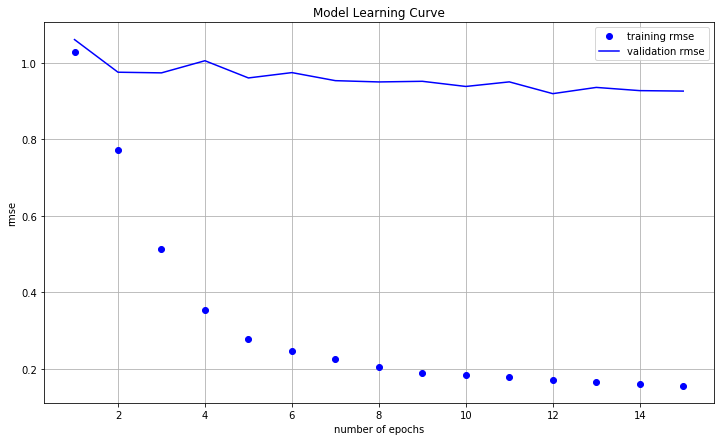

In [331]:
plot_learning_curve(history, 'rmse')

### Neural Matrix Factorization (NeuMF) model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [367]:
# load best model
NeuMF_model = get_NeuMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=100,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model = load_trained_model(NeuMF_model, os.path.join(data_path, 'tmp/modelNeuMFBest.hdf5'))
# make prediction using test data
# predictions = NeuMF_model.predict([df_test.userId.values, df_test.movieId.values])
# # get the RMSE
# error = rmse(df_test.rating.values, predictions)
# print('The out-of-sample RMSE of rating predictions is', round(error, 4))
my_ind = np.ones(num_items) * 611
my_films = np.arange(0, num_items)
# print(my_ind.shape)
# print(my_films.shape)
predictions = NeuMF_model.predict([my_ind, my_films])
sort_index = sorted(range(len(predictions)), key=lambda k: predictions[k][0], reverse=True)

for i in range(20):
    ind = df_ratings[df_ratings['movieId'] == sort_index[i]].index.tolist()[0]
    print(k.iloc[ind]['movieId'], k.iloc[ind]['title'], predictions[sort_index[i]])
    
print('\npredictions on your films:\n')

print(k[k['userId']== 611].iloc[:,2:4])



318 Shawshank Redemption, The (1994) [4.3408403]
1196 Star Wars: Episode V - The Empire Strikes Back (1980) [4.170156]
3275 Boondock Saints, The (2000) [4.1524825]
4306 Shrek (2001) [4.1163282]
898 Philadelphia Story, The (1940) [4.0814204]
1213 Goodfellas (1990) [4.0585065]
168252 Logan (2017) [4.03913]
2959 Fight Club (1999) [4.027507]
1276 Cool Hand Luke (1967) [4.026407]
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) [4.0255723]
260 Star Wars: Episode IV - A New Hope (1977) [4.022367]
356 Forrest Gump (1994) [4.022165]
177593 Three Billboards Outside Ebbing, Missouri (2017) [4.007093]
4011 Snatch (2000) [4.0061016]
142488 Spotlight (2015) [3.9989533]
1136 Monty Python and the Holy Grail (1975) [3.9970407]
1704 Good Will Hunting (1997) [3.9961286]
1233 Boot, Das (Boat, The) (1981) [3.9954758]
1262 Great Escape, The (1963) [3.9952197]
1197 Princess Bride, The (1987) [3.988771]

predictions on your films:

        rating                            

In [268]:
print(df_test.rating.values)
print(predictions)
print(df_test.userId.values)
print(len(df_ratings[df_ratings['userId'] == 611]))

[4.  2.5 1.5 ... 1.5 5.  5. ]
[[3.4052823]
 [3.4052823]
 [3.4052823]
 ...
 [3.4052823]
 [3.4052823]
 [3.4052823]]
[590  28 508 ... 480 474  84]
23


## Observations
1. ALS's out-of-sample RMSE is 0.9206
2. GMF's out-of-sample RMSE is 0.9237
3. MLP's out-of-sample RMSE is 0.9094
4. NeuMF's out-of-sample RMSE is 0.9059
5. Rating prediction out-of-sample performance in terms of RMSE (the lower the better): NeuMF < MLP < ALS < GMF
6. The best model is NeuMF

## Conclusion

1. Deep neural networks can achieve a better performance in recommendation system, specifically at Collaborative Filtering
2. As you increase the depth of the network or broaden the network branches, the performance of the model also increases 